# CHAPTER 25 and 26 : Decentralized Optimization

### This code runs simulations for Example ? and generates figures ???  from Chapter 25 and 26: Decentralized Optimization (vol I)
TEXT: A. H. Sayed, INFERENCE AND LEARNING FROM DATA, Cambridge University Press, 2022.

<div style="text-align: justify">
DISCLAIMER:  This computer code is  provided  "as is"   without  any  guarantees.
Practitioners  should  use it  at their own risk.  While  the  codes in  the text 
are useful for instructional purposes, they are not intended to serve as examples 
of full-blown or optimized designs. The author has made no attempt at optimizing 
the codes, perfecting them, or even checking them for absolute accuracy. In order 
to keep the codes at a level  that is  easy to follow by students, the author has 
often chosen to  sacrifice  performance or even programming elegance in  lieu  of 
simplicity. Students can use the computer codes to run variations of the examples 
shown in the text. 
</div>

The Jupyter notebook and python codes are developed by Semanur Avşar 

Required Libraries:

1. numpy
2. matplotlib

Required Functions:

1. generate_logistic
2. logistic_minimizer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [2]:
from generate_logistic import generate_logistic
from logistic_minimizer import logistic_minimizer

In [3]:
#########################################################################
###   function [p_vector]  = find_Perron_vector(combination_policy)
#########################################################################

# April 5, 2014 (AHS)

# This function finds the Perron vector of a combination policy, namely,
# the vector that satisfies
# Ap=p, 1^T p =1, p_k>0
#
# If the matrix A is primitive, then all entries p_k are strictly positive.
#
# TEXT: A. H. Sayed, INFERENCE AND LEARNING FROM DATA, 
#       Cambridge University Press, 2022.
#
# DISCLAIMER:  This computer code is  provided  "as is"   without  any  guarantees.
# Practitioners  should  use it  at their own risk.  While  the  codes in  the text 
# are useful for instructional purposes, they are not intended to serve as examples 
# of full-blown or optimized designs.  The author has made no attempt at optimizing 
# the codes, perfecting them, or even checking them for absolute accuracy. In order 
# to keep the codes at a level  that is  easy to follow by students, the author has 
# often chosen to  sacrifice  performance or even programming elegance in  lieu  of 
# simplicity. Students can use the computer codes to run variations of the examples 
# shown in the text. 

import numpy as np
import scipy.linalg as la

def find_Perron_vector(combination_policy):
    
#INPUT
# combination_policy: NxN stochastic matrix (left, doubly, or right).
#
#OUTPUT
# p_vector: Perron eigenvector of A (a column vector); its entries are positive and add up to one since the topolgy is strongly-connected.
#

    A = combination_policy  # Combination matrix
    N = max(A.shape)
    eigenvalues, eigenvectors = la.eig(A)  # Eigenvalue decomposition
    idx = np.argmax(np.abs(eigenvalues))  # Index of maximum magnitude eigenvalue of A
    p = eigenvectors[:, idx]  # Extracting the corresponding eigenvector
    p = p / np.sum(p)  # Normalizing the sum of its entries to one

    p_vector = p  # Perron eigenvector

    r = np.ones(N)
    for i in range(1000):
        r = A.dot(r)

    return p_vector, r / np.linalg.norm(r)

In [4]:
#######################################################################
###   function plot_topology(Adjacency,Coordinates,Color)
#######################################################################

# April 2, 2014 (AHS)

# This function plots a network topology

# TEXT: A. H. Sayed, INFERENCE AND LEARNING FROM DATA, 
#       Cambridge University Press, 2022.
#
# DISCLAIMER:  This computer code is  provided  "as is"   without  any  guarantees.
# Practitioners  should  use it  at their own risk.  While  the  codes in  the text 
# are useful for instructional purposes, they are not intended to serve as examples 
# of full-blown or optimized designs.  The author has made no attempt at optimizing 
# the codes, perfecting them, or even checking them for absolute accuracy. In order 
# to keep the codes at a level  that is  easy to follow by students, the author has 
# often chosen to  sacrifice  performance or even programming elegance in  lieu  of 
# simplicity. Students can use the computer codes to run variations of the examples 
# shown in the text. 

#INPUT
# Adjacency: size NxN; A[a,b] =  1 if a and b are connected; otherwise zero.
#
# Coordinates: Nx2 matrix containing the (x,y) location coordinates of the agents in the square region [0,1.2]x[0,1.2]; 
#              each row corresponds to one agent
#
# Color: a vector of size Nx1. Location k in this vector is set to:
#        0 if the corresponding agent should have one color (yellow)
#        1 if the corresponding agent should have a second color (red)
#        2 if the corresponding agent should have a third color (green)


import numpy as np
import matplotlib.pyplot as plt

def plot_topology(Adjacency, Coordinates, Color):

    A = Adjacency  # Adjacency matrix
    N = max(A.shape)  # Number of agents

    x_coordinates = Coordinates[:, 0]  # x-coordinates of agents
    y_coordinates = Coordinates[:, 1]  # y-coordinates of agents

    plt.figure()
    plt.axis([0, 1.2, 0, 1.2])
    plt.axis('square')
    plt.grid(True)
    plt.xlabel('x-coordinate')
    plt.ylabel('y-coordinate')

    for k in range(N):
        for l in range(N):
            if A[k, l] > 0:
                plt.plot([x_coordinates[k], x_coordinates[l]], [y_coordinates[k], y_coordinates[l]], 'b-', linewidth=1.5)

    for k in range(N):
        if Color[k] == 0:  # Yellow
            plt.plot(x_coordinates[k], y_coordinates[k], 'o', markeredgecolor='b', markerfacecolor='y', markersize=10)
        elif Color[k] == 1:  # Red
            plt.plot(x_coordinates[k], y_coordinates[k], 'o', markeredgecolor='b', markerfacecolor='r', markersize=10)
        else:  # Green
            plt.plot(x_coordinates[k], y_coordinates[k], 'o', markeredgecolor='b', markerfacecolor='g', markersize=10)

    for k in range(N):
        plt.text(x_coordinates[k] + 0.03, y_coordinates[k] + 0.03, str(k + 1), fontsize=7)

    plt.show()

In [5]:
######################################################################
###   function [Combination_Matrix, p_Vector]  = 
###   generate_combination_policy(Adjacency,b,Type)
######################################################################

# March 28, 2014 (AHS)

# This function generates various types of combination policies
# and returns the combination matrix and its Perron eigenvector.
#
#
# TEXT: A. H. Sayed, INFERENCE AND LEARNING FROM DATA, 
#       Cambridge University Press, 2022.
#
# DISCLAIMER:  This computer code is  provided  "as is"   without  any  guarantees.
# Practitioners  should  use it  at their own risk.  While  the  codes in  the text 
# are useful for instructional purposes, they are not intended to serve as examples 
# of full-blown or optimized designs.  The author has made no attempt at optimizing 
# the codes, perfecting them, or even checking them for absolute accuracy. In order 
# to keep the codes at a level  that is  easy to follow by students, the author has 
# often chosen to  sacrifice  performance or even programming elegance in  lieu  of 
# simplicity. Students can use the computer codes to run variations of the examples 
# shown in the text. 

#INPUT
# Adjacency: A[a,b] =  1 if a and b are connected; otherwise zero; it is a square matrix
#
# Type: designates the type of the combination policy desired:
#       `uniform':    uniform or averaging rule
#       `metropolis': Metropolis rule
#       'reldeg':     relative-degree rule
#       'reldegvar':  relative-degree variance rule (only for MSE networks; in
#                     this case, the entries of the vector b should be the inverses of the
#                     sigma_{v,k}^2 at the agents)
#       'relvar':     relative variance rule (only for MSE networks; in
#                     this case, the entries of the vector b should be the inverses of
#                     \mu_k^2 \sigma_{v,k}^2 Tr(R_{u,k}).
#       'hastings':   Hastings rule (in this case, the entries of the vector b should be 
#                     the theta_k^2 = Tr(H^{-1}G_k in the general case; for MSE networks 
#                     with uniform R_{u}, theta_k^2 = 2 \sigma_{v,k}^2 M).
#
# b: auxiliary column vector with the same number of entries as the number of nodes.
#    Its entries are neeeded to construct the `reldegvar', `relvar', and Hastings rules.
#
#OUTPUT
# Combination_Matrix
#
# p_vector: Perron eigenvector of A (a column vector); its entries are positive and add up to one since the topolgy is strongly-connected.
#

import numpy as np

def generate_combination_policy(Adjacency, b, Type):

    A = Adjacency  # Adjacency matrix
    N = max(A.shape)

    # Determine the number of neighbors of each node from the adjacency matrix
    num_nb = np.sum(A, axis=1)

    W = np.zeros((N, N))

    if Type.lower() == 'uniform':
        # Uniform or averaging rule (left-stochastic)
        W = A;
        for k in range(N) :
          W[k,:] = W[k,:]/np.sum(W[k,:])

    elif Type.lower() == 'metropolis':
        # Metropolis rule (doubly-stochastic)
        for k in range(N) :
            for l in range(N):
                W[k, l] = A[k, l] / max(num_nb[k], num_nb[l])
            W[k, k] = 1 + W[k, k] - np.sum(W[k, :])

    elif Type.lower() == 'reldeg':
        # Relative-degree rule (left-stochastic)
        for k in range(N) :
            W[k,:] = (A[k,:]*num_nb.T)/(A[k,:] @ num_nb)
        end

    elif Type.lower() == 'reldegvar':
        # Relative-degree variance rule (left-stochastic)
        wb = num_nb * b
        for k in range(N) :
            W[k,:] = (A[k,:]*wb.T)/(A[k,:] @ wb)

    elif Type.lower() == 'relvar':
        # Relative variance rule (left-stochastic)
        for k in range(N) :
            W[k,:] = (A[k,:]*b.T)/(A[k,:] @ b)

    elif Type.lower() == 'hastings':
        # General Hastings rule (left-stochastic)
        for k in range(N) :
            for l in range(N):
                W[k, l] = A[k, l] * b[k] / max(num_nb[k] * b[k], num_nb[l] * b[l])
            W[k, k] = 1 + W[k, k] - np.sum(W[k, :])

    else:
        print('Unknown rule of combination!')
        return None, None

    Combination_Matrix = W.T  # The desired combination matrix is the transpose of W

    # Finding the Perron eigenvector
    _, D, V = np.linalg.svd(Combination_Matrix)  # Singular value decomposition
    idx = np.argmax(np.abs(D))
    p = V[idx, :]
    p = p / np.sum(p)  # Normalize the sum of its entries to one

    p_Vector = p  # Perron eigenvector

    return Combination_Matrix, p_Vector

In [26]:
#############################################################################################
###   function [Adjacency,Laplacian,Algebraic_Connectivity,Degree_Vector,Coordinates] = 
###   generate_topology(Num_nodes,Type,Parameter)
#############################################################################################

# March 27, 2014 (AHS)

# This function generates a random network topology with N agents and 
# returns its adjacency and Laplacian matrices, the algebraic connectivity,
# and a column vector containing the degrees of the various nodes.
# The function also plots the network if it turns out to be connected.
# The function allows the network to be generated according to two
# criteria, as explained below.
#
# TEXT: A. H. Sayed, INFERENCE AND LEARNING FROM DATA, 
#       Cambridge University Press, 2022.
#
# DISCLAIMER:  This computer code is  provided  "as is"   without  any  guarantees.
# Practitioners  should  use it  at their own risk.  While  the  codes in  the text 
# are useful for instructional purposes, they are not intended to serve as examples 
# of full-blown or optimized designs.  The author has made no attempt at optimizing 
# the codes, perfecting them, or even checking them for absolute accuracy. In order 
# to keep the codes at a level  that is  easy to follow by students, the author has 
# often chosen to  sacrifice  performance or even programming elegance in  lieu  of 
# simplicity. Students can use the computer codes to run variations of the examples 
# shown in the text. 

#INPUT
# Num_nodes: number of nodes in the network

# Type = 1: Nodes that are within a certain radius from each other are declated neighbors.
# Type = 2: Two nodes are declared neighbors probabilisitically according to a binomial distribution.

# Parameter (always positive and smaller than one):
#      for Type=1, this variable refers to the radius: in the square region [0,1.2]x[0,1.2], nodes within 
#          this value from each other are declared to be neighbors, e.g., radius = 0.3.
#      for Type 2, this variable refers to the probability of establishing a connection. Nodes a and b will
#          be neighbors with this probability value.

#OUTPUT
# Adjacency: A[a,b] =  1 if a and b are connected; otherwise zero.

# Laplacian: L[a,b] = -1 if a and b are connected; L[a,a] = degree(a)-1.
# The degree of an agent a is equal to the number of its neighbors including itself.

# Algebraic_Connectivity: smallest second eigenvalue of L; if nonzero, then the network is connected.
#                         Since in the topology construction, every node is assumed connected to itself, 
#                         the resulting topology will be strongly-connected.
#
# Degree_Vector: a vector containing the degrees (number of neighbors) of the nodes
#
# Coordinates: Nx2 matrix containing the (x,y) location coordinates of the agents; each row corresponds to one agent

import numpy as np

def generate_topology(Num_nodes, Type, Parameter):
    N = Num_nodes  # Number of nodes.
    A = np.zeros((N, N))  # Adjacency matrix.
    L = np.zeros((N, N))  # Laplacian matrix.

    if Type == 1:
        r = Parameter  # Nodes within this radius from each other are declared to be neighbors.
    else:
        p = Parameter  # Nodes k and l are declared neighbors according to a binomial distribution with probability p.

    # We first generate N random (x,y) coordinates in the square region [0,1.2]x[0,1.2]
    x_coordinates = np.random.rand(N) + 0.1
    y_coordinates = np.random.rand(N) + 0.1
    Coordinates = np.column_stack((x_coordinates, y_coordinates))

    # We next determine which nodes are neighbors of each other and find the adjacency matrix.
    if Type == 1:  # distance criterion
        for k in range(N):
            for l in range(N):
                d = np.sqrt((x_coordinates[k] - x_coordinates[l]) ** 2 + (y_coordinates[k] - y_coordinates[l]) ** 2)
                if d <= r:
                    A[k, l] = 1  # set entry in adjacency matrix to one if nodes k and l should be neighbors.

    if Type == 2:  # binomial criterion
        for k in range(N):
            A[k, k] = 1  # a node is always connected to itself in this construction
            for l in range(k + 1, N):
                b = np.random.rand()  # generate a uniform random variable in the interval [0,1]
                if b <= p:  # if b falls within the interval [0,p], then we connect the nodes
                    A[k, l] = 1  # set entry in adjacency matrix to one if nodes k and l should be neighbors.
                    A[l, k] = 1

    Adjacency = A  # adjacency matrix.

    # We determine the number of neighbors of each node from the adjacency matrix
    num_nb = np.zeros(N).reshape(-1,1)
    for k in range(N):
        num_nb[k] = np.sum(A[k, :])
    Degree_Vector = num_nb  # vector of degrees for the various nodes

    # We now compute the Laplacian matrix L and check if the network is connected
    # by verifying whether the second smallest eigenvalue of L is positive.
    for k in range(N):
        L[k, k] = max(0, np.sum(A[k, :]) - 1)  # set diagonal entry to zero if degree-1 for node k is negative.
        for l in range(k + 1, N):
            L[k, l] = -1 * A[k, l]
            L[l, k] = -1 * A[l, k]

    sigma = np.linalg.svd(L, compute_uv=False)  # vector of singular values of L.

    Laplacian = L  # Laplacian matrix
    Algebraic_Connectivity = sigma[N - 2]  # algebraic connectivity

    if sigma[N - 2] < 1e-4:  # checking if the second smallest singular value is positive (sufficiently away from zero).
        return None  # network is not connected; returns None to indicate a failure.
    else:
        return Adjacency, Laplacian, Algebraic_Connectivity, Degree_Vector, Coordinates

# else
#     # plot the network
#     figure
#     hold on
#     for k=1:N
#         for l=1:N
#             if A(k,l)>0
#                 plot([x_coordinates(k),x_coordinates(l)],[y_coordinates(k),y_coordinates(l)],'b-','LineWidth',1.5);
#             end
#         end
#     end
#     plot(x_coordinates,y_coordinates,'o','MarkerEdgeColor','b','MarkerFaceColor','y','MarkerSize',10);
#     axis([0,1.2,0,1.2]);
#     axis square
#     grid
#     xlabel('x-coordinate')
#     ylabel('y-coordinate')
# 
#     for k=1:N
#       text(x_coordinates(k)+0.03,y_coordinates(k)+0.03,num2str(k),'Fontsize',7);
#     end  


Wait...generating data
network generated


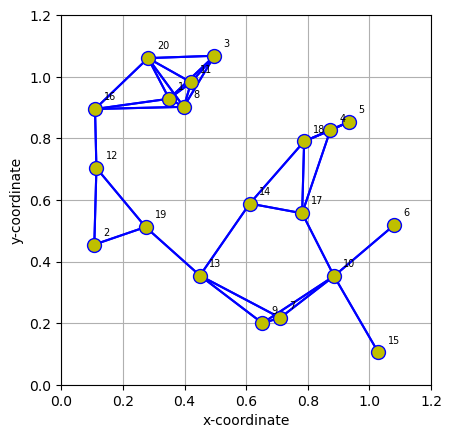

Press a key to continue



''

In [28]:
########################################################################
###     Chapter 25: Decentralized Optimization  I: Primal Methods
###     Chapter 26: Decentralized Optimization II: Primal-Dual Methods
########################################################################

# May 2020

# This code generates figures 8 and 9 from Chapter 25: 
# Decentralized Optimization  I: Primal Methods (vol I)

# The code also generates figures 1 and 2 from Chapter 26: 
# Decentralized Optimization II: Primal-Dual Methods (vol I)

# Runs simulations for Example 6 in Chapter 25
# Runs simulations for Examples 1 and 2 in Chapter 26

# TEXT: A. H. Sayed, INFERENCE AND LEARNING FROM DATA, 
#       Cambridge University Press, 2022.

# DISCLAIMER:  This computer code is  provided  "as is"   without  any  guarantees.
# Practitioners  should  use it  at their own risk.  While  the  codes in  the text 
# are useful for instructional purposes, they are not intended to serve as examples 
# of full-blown or optimized designs.  The author has made no attempt at optimizing 
# the codes, perfecting them, or even checking them for absolute accuracy. In order 
# to keep the codes at a level  that is  easy to follow by students, the author has 
# often chosen to  sacrifice  performance or even programming elegance in  lieu  of 
# simplicity. Students can use the computer codes to run variations of the examples 
# shown in the text. 

#################################################################################
# Runs EXAMPLE 6 from Chapter 25 (Simulating consensus and ATC diffusion
# generates figure 8 and 9 from Chapter 25
#################################################################################

#################################################################################
# Runs EXAMPLE 1 from Chapter 26 (Simulating EXTRA and EXACT diffusion)
# Runs EXAMPLE 2 from Chapter 26 (Simulating DIGing and ATC gradient tracking)
# generates figures 1 and 2 from Chapter 26
#################################################################################

rho = 0.001    # l2-regularization parameter
mu  = 0.01     # step-size 

M = 10     # feature size at each agent
K = 20     # number of agents in the network
Nk = 200   # number of data points per agent
N = K*Nk   # total number of data points across the graph

L = 10       # averaging over this many experiments
runs = 1000  # multiple runs at each agent using random reshuffling
alpha = (Nk/N)*np.ones(K) # scalings for all agents

random_agent = np.random.randint(K) # select a random agent to plot learning curves

type_policy = 'metropolis'  # Type of combination policy: uniform, metropolis, reldeg, reldegvar, relvar, hastings
type_topology = 1  # Use 1 for neighbors to be decided by closeness in distance; use 2 for neighbors to be decided randomly using binary decisions
radius = 0.3  # Size of radius to determine which nodes are neighbors for type_topology = 1
prob = 0.2  # Probability value to determine which nodes are neighbors for type_topology = 2

print('Wait...generating data')

# Generating the graph topology
if type_topology == 1:
    parameter = radius
else:
    parameter = prob

algebraic_connectivity = 0
while algebraic_connectivity < 1e-4:  # Keep trying until a connected topology is chosen
    result = generate_topology(K, type_topology, parameter)
    if result is not None:
        adjacency, laplacian, algebraic_connectivity, degree, coordinates = result
        break
        
print('network generated')

color = np.zeros(K)  # Color map for the agents: 0=yellow, 1=red, 2=green

# figure 8 from Chapter 25 (graph topology)
plot_topology(adjacency,coordinates,color)

b = np.ones(K).reshape(-1,1)
A, p = generate_combination_policy(adjacency, b, type_policy)  # A is the combination policy, p is its Perron eigenvector

A_EXTRA = 0.5 * (np.eye(K, K) + A)  # Combination matrix for EXTRA

print('Press a key to continue')
input()  # Use input() to wait for a key press in Python

In [ ]:
### Generating the logistic data and global minimizer wstar
zo = np.random.rand(M).reshape(-1,1)  # underlying parameter model for logistic data
p, gamma_vec, H = generate_logistic(N,zo,0) # logistic model with zero offset
wstar, Pstar, thetastar = logistic_minimizer(rho, gamma_vec, H,0) # returns global minimizer wstar 

print('checkpoint 1')

#H = H + 0.01*randn(M,N);
H_agents = []  # List to store feature vectors at the agents
gamma_agents = []  # List to store labels {+1,-1} at the agents

for k in range(1, K + 1):
    # Extract feature vectors for agent k
    H_k = H[:, (k - 1) * Nk:k * Nk]
    H_agents.append(H_k)

    # Extract labels (gamma) for agent k
    gamma_k = gamma_vec[(k - 1) * Nk:k * Nk]
    gamma_agents.append(gamma_k)

print('checkpoint 2')

In [64]:
P_ATC  = np.zeros((L,runs))   # ATC diffusion
P_CONS = np.zeros((L,runs))   # consensus
P_EXTRA = np.zeros((L,runs))  # EXTRA
P_EXACT = np.zeros((L,runs))  # EXACT diffusion
P_GRAD = np.zeros((L,runs))  # ATC gradient tracking
P_DING = np.zeros((L,runs))   # DIGing

P_ATC_mean   = np.zeros(runs).reshape(-1,1)
P_CONS_mean  = np.zeros(runs).reshape(-1,1)
P_EXTRA_mean = np.zeros(runs).reshape(-1,1)
P_EXACT_mean = np.zeros(runs).reshape(-1,1)
P_GRAD_mean  = np.zeros(runs).reshape(-1,1)
P_DING_mean = np.zeros(runs).reshape(-1,1)

psi_ATC = np.zeros((M,K))  # diffusion ATC
w_ATC = np.zeros((M,K))
  
psi_CONS = np.zeros((M,K)) # Consensus
w_CONS = np.zeros((M,K))

psi_EXACT = np.zeros((M,K)) # EXACT diffusion
w_EXACT = np.zeros((M,K))
psi_EXACT_before = np.zeros((M,K))
phi_EXACT = np.zeros((M,K))
  
psi_EXTRA = np.zeros((M,K)) # EXTRA
w_EXTRA = np.zeros((M,K))
psi_EXTRA_before = np.zeros((M,K))
phi_EXTRA = np.zeros((M,K))

psi_GRAD = np.zeros((M,K)) # ATC gradient tracking
w_GRAD = np.zeros((M,K))
phi_GRAD = np.zeros((M,K))
w_GRAD_before = np.zeros((M,K))
s_vec = np.zeros((M,K))
H_previous = np.zeros((M,K))
gamma_previous = np.zeros(K).reshape(-1,1)


# Initialization for ATC gradient tracking; iterating over agents
for k in range(K):
    Hk = H_agents[k]  # Feature data at agent k
    gammak = gamma_agents[k]  # Labels at agent k
    Zidx = np.random.randint(Nk)
    h_u = Hk[:, Zidx]  # Feature vector
    gamma_u = gammak[Zidx]  # Label
    H_previous[:, k] = h_u
    gamma_previous[k] = gamma_u
    a = np.exp(-gamma_u * np.dot(h_u, w_GRAD_before[:, k].reshape(-1,1)))
    s_vec[:, k] = 2 * rho * w_GRAD_before[:, k] - gamma_u * h_u * a / (1 + a)  # Gradient vector of regularized loss

print('checkpoint 3')

# Update w_GRAD
for k in range(K):
    for aa in range(K):
        X = 2 * w_GRAD_before[:, aa] - mu * alpha[aa] * s_vec[:, aa]
        w_GRAD[:, k] = w_GRAD[:, k] + A[aa, k] * X
        
print('checkpoint 4')

psi_DING = np.zeros((M,K)) # DIGing
w_DING = np.zeros((M,K))
phi_DING = np.zeros((M,K))
w_DING_before = np.zeros((M,K))
s_vec = np.zeros((M,K))
H_previous_ding = np.zeros((M,K))
gamma_previous_ding = np.zeros(K).reshape(-1,1)


# Initialization for DIGing
for k in range(K):
    Hk = H_agents[k]  # Feature data at agent k
    gammak = gamma_agents[k]  # Labels at agent k
    Zidx = np.random.randint(Nk)
    h_u = Hk[:, Zidx]  # Feature vector
    gamma_u = gammak[Zidx]  # Label
    H_previous_ding[:, k] = h_u
    gamma_previous_ding[k] = gamma_u
    a = np.exp(-gamma_u * np.dot(h_u, w_DING_before[:, k].reshape(-1,1)))
    s_vec[:, k] = 2 * rho * w_DING_before[:, k] - gamma_u * h_u * a / (1 + a)  # Gradient vector
    
print('checkpoint 5')

# Update w_DING
for k in range(K):
    for aa in range(K):
        w_DING[:, k] = w_DING[:, k] + 2 * A[aa, k] * w_DING_before[:, aa]
    w_DING[:, k] = w_DING[:, k] - mu * alpha[k] * s_vec[:, k]

print('checkpoint 6')    

checkpoint 3
checkpoint 4
checkpoint 5
checkpoint 6


In [ ]:
from tqdm import tqdm

for ell in tqdm(range(L)):  # Averaging over L experiments
    print(ell)
    for R in range(runs):  # Multiple runs at each agent using uniform sampling
        for m in range(N):  # Empirical risk at START of each run for some random agent
            h_m = H[:, m]  # Feature vector
            gamma_m = gamma_vec[m]  # Label

            a = 1 + np.exp(-gamma_m * np.dot(h_m, w_ATC[:, random_agent].reshape(-1,1)))  # At randomly selected agent
            P_ATC[ell, R] = P_ATC[ell, R] + np.log(a)

            a = 1 + np.exp(-gamma_m * np.dot(h_m, w_CONS[:, random_agent].reshape(-1,1)))  # At randomly selected agent
            P_CONS[ell, R] = P_CONS[ell, R] + np.log(a)

            a = 1 + np.exp(-gamma_m * np.dot(h_m, w_EXTRA[:, random_agent].reshape(-1,1)))  # At randomly selected agent
            P_EXTRA[ell, R] = P_EXTRA[ell, R] + np.log(a)

            a = 1 + np.exp(-gamma_m * np.dot(h_m, w_EXACT[:, random_agent].reshape(-1,1)))  # At randomly selected agent
            P_EXACT[ell, R] = P_EXACT[ell, R] + np.log(a)

            a = 1 + np.exp(-gamma_m * np.dot(h_m, w_GRAD[:, random_agent].reshape(-1,1)))  # At randomly selected agent
            P_GRAD[ell, R] = P_GRAD[ell, R] + np.log(a)

            a = 1 + np.exp(-gamma_m * np.dot(h_m, w_DING[:, random_agent].reshape(-1,1)))  # At randomly selected agent
            P_DING[ell, R] = P_DING[ell, R] + np.log(a)

        P_ATC[ell, R] = (1 / N) * P_ATC[ell, R]  # ATC
        P_ATC[ell, R] = P_ATC[ell, R] + rho * np.linalg.norm(w_ATC[:, random_agent], 2) ** 2  # Risk value at start of epoch R

        P_CONS[ell, R] = (1 / N) * P_CONS[ell, R]  # Consensus
        P_CONS[ell, R] = P_CONS[ell, R] + rho * np.linalg.norm(w_CONS[:, random_agent], 2) ** 2  # Risk value at start of epoch R

        P_EXTRA[ell, R] = (1 / N) * P_EXTRA[ell, R]  # EXTRA
        P_EXTRA[ell, R] = P_EXTRA[ell, R] + rho * np.linalg.norm(w_EXTRA[:, random_agent], 2) ** 2  # Risk value at start of epoch R

        P_EXACT[ell, R] = (1 / N) * P_EXACT[ell, R]  # EXACT DIFFUSION
        P_EXACT[ell, R] = P_EXACT[ell, R] + rho * np.linalg.norm(w_EXACT[:, random_agent], 2) ** 2  # Risk value at start of epoch R

        P_GRAD[ell, R] = (1 / N) * P_GRAD[ell, R]  # ATC gradient tracking
        P_GRAD[ell, R] = P_GRAD[ell, R] + rho * np.linalg.norm(w_GRAD[:, random_agent], 2) ** 2  # Risk value at start of epoch R

        P_DING[ell, R] = (1 / N) * P_DING[ell, R]  # DIGing
        P_DING[ell, R] = P_DING[ell, R] + rho * np.linalg.norm(w_DING[:, random_agent], 2) ** 2  # Risk value at start of epoch R

        Z = {}
        for k in range(K):
            Z[k] = np.random.permutation(Nk)  # Random reshuffling at each agent

        for m in range(Nk):  # Iterating over data at each agent
            for k in range(K):  # Iterating over agents
                Hk = H_agents[k]  # Feature data at agent k
                gammak = gamma_agents[k]  # Labels at agent k
                Zk = Z[k]
                h_u = Hk[:, Zk[m]]  # Feature vector
                gamma_u = gammak[Zk[m]]  # Label

                # ATC diffusion
                a = np.exp(-gamma_u * np.dot(h_u, w_ATC[:, k].reshape(-1,1)))
                s = 2 * rho * w_ATC[:, k] - gamma_u * h_u * a / (1 + a)  # Gradient vector of regularized loss
                psi_ATC[:, k] = w_ATC[:, k] - mu * alpha[k] * s

                # Consensus
                for kkk in range(K):
                    psi_CONS[:, kkk] = np.zeros(M)
                    for aa in range(K):
                        psi_CONS[:, kkk] = psi_CONS[:, kkk] + A[aa, kkk] * w_CONS[:, aa]

                # EXTRA
                a = np.exp(-gamma_u * np.dot(h_u, w_EXTRA[:, k].reshape(-1,1)))
                s = 2 * rho * w_EXTRA[:, k] - gamma_u * h_u * a / (1 + a)  # Gradient of regularized loss
                phi_EXTRA[:, k] = np.zeros(M)
                for aa in range(K):
                    phi_EXTRA[:, k] = phi_EXTRA[:, k] + A_EXTRA[aa, k] * w_EXTRA[:, aa]
                psi_EXTRA_before[:, k] = psi_EXTRA[:, k]
                psi_EXTRA[:, k] = phi_EXTRA[:, k] - mu * alpha[k] * s

                # EXACT diffusion
                a = np.exp(-gamma_u * np.dot(h_u, w_EXACT[:, k].reshape(-1,1)))
                s = 2 * rho * w_EXACT[:, k] - gamma_u * h_u * a / (1 + a)  # Gradient of regularized loss
                
                psi_EXACT_before[:, k] = psi_EXACT[:, k]
                psi_EXACT[:, k] = w_EXACT[:, k] - mu * alpha[k] * s
                phi_EXACT[:, k] = w_EXACT[:, k] + (psi_EXACT[:, k] - psi_EXACT_before[:, k])

                # ATC gradient tracking
                a = np.exp(-gamma_u * np.dot(h_u, w_GRAD[:, k].reshape(-1,1)))
                s = 2 * rho * w_GRAD[:, k] - gamma_u * h_u * a / (1 + a)  # Gradient of regularized loss
                h_before = H_previous[:, k]
                gamma_before = gamma_previous[k]
                H_previous[:, k] = h_u
                gamma_previous[k] = gamma_u
                a_before = np.exp(-gamma_before * np.dot(h_before, w_GRAD_before[:, k].reshape(-1,1)))
                s_before = 2 * rho * w_GRAD_before[:, k] - gamma_before * h_before * a_before / (1 + a_before)
                psi_GRAD[:, k] = 2 * w_GRAD[:, k]
                for aa in range(K):
                    psi_GRAD[:, k] = psi_GRAD[:, k] - A[aa, k] * w_GRAD_before[:, aa]
                phi_GRAD[:, k] = psi_GRAD[:, k] - mu * alpha[k] * (s - s_before)

                # DIGing
                psi_DING[:, k] = 2 * w_DING[:, k]
                for aa in range(K):
                    psi_DING[:, k] = psi_DING[:, k] - A[aa, k] * w_DING_before[:, aa]

            for k in range(K):
                Hk = H_agents[k]  # Feature data at agent k
                gammak = gamma_agents[k]  # Labels at agent k
                Zk = Z[k]
                h_u = Hk[:, Zk[m]]  # Feature vector
                gamma_u = gammak[Zk[m]]  # Label

                # Consensus
                a = np.exp(-gamma_u * np.dot(h_u, w_CONS[:, k].reshape(-1,1)))  # Consensus
                s = 2 * rho * w_CONS[:, k] - gamma_u * h_u * a / (1 + a)  # Gradient of regularized loss
                w_CONS[:, k] = psi_CONS[:, k] - mu * alpha[k] * s

                # ATC diffusion
                w_ATC[:, k] = np.zeros(M)
                for aa in range(K):
                    w_ATC[:, k] = w_ATC[:, k] + A[aa, k] * psi_ATC[:, aa]

                # EXTRA
                w_EXTRA[:, k] = phi_EXTRA[:, k] + (psi_EXTRA[:, k] - psi_EXTRA_before[:, k])

                # EXACT Diffusion
                w_EXACT[:, k] = np.zeros(M)
                for aa in range(K):
                    w_EXACT[:, k] = w_EXACT[:, k] + A_EXTRA[aa, k] * phi_EXACT[:, aa]

                # ATC gradient tracking
                w_GRAD_before[:, k] = w_GRAD[:, k]
                w_GRAD[:, k] = np.zeros(M)
                for aa in range(K):
                    w_GRAD[:, k] = w_GRAD[:, k] + A[aa, k] * phi_GRAD[:, aa]

                # DIGing
                a = np.exp(-gamma_u * np.dot(h_u, w_DING[:, k].reshape(-1,1)))
                s = 2 * rho * w_DING[:, k] - gamma_u * h_u * a / (1 + a)  # Gradient vector
                h_before = H_previous_ding[:, k]
                gamma_before = gamma_previous_ding[k]
                H_previous_ding[:, k] = h_u
                gamma_previous_ding[k] = gamma_u
                a_before = np.exp(-gamma_before * np.dot(h_before, w_DING_before[:, k].reshape(-1,1)))
                s_before = 2 * rho * w_DING_before[:, k] - gamma_before * h_before * a_before / (1 + a_before)  # Gradient vector

                phi_DING[:, k] = np.zeros(M)
                for aa in range(K):
                    phi_DING[:, k] = phi_DING[:, k] + A[aa, k] * psi_DING[:, aa]
                w_DING_before[:, k] = w_DING[:, k]
                w_DING[:, k] = phi_DING[:, k] - mu * alpha[k] * (s - s_before)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

0


checkpoint 7
Global minimizer, ATC diffusion, consensus, EXTRA, EXACT diffusion, ATC gradient tracking
[[0.89199706]
 [1.03325572]
 [0.72365266]
 [0.11513219]
 [0.17146454]
 [0.87938132]
 [0.1784586 ]
 [0.4647639 ]
 [0.73553094]
 [0.00821494]] ,
 [ 0.64907173  0.74530763  0.52556966  0.08524357  0.12377375  0.64169687
  0.13013052  0.33335138  0.53115059 -0.00186285] ,
 [ 0.64918647  0.74511526  0.52560178  0.08519041  0.12385713  0.64167853
  0.13013136  0.33337678  0.53122234 -0.00200296] ,
 [ 0.36654157  1.31485981  0.56593927 -0.37366439 -0.28558979  0.17982379
  0.06092198  0.55992121  0.04540233 -0.10563541] ,
 [ 0.36657474  1.31480287  0.56605431 -0.37345508 -0.28558124  0.17963032
  0.06105516  0.55994292  0.04556545 -0.10560029] ,
 [ 1.88810183  0.82259383  0.65776406  0.27192503 -0.24117359  0.54971459
 -0.28399236  0.37937738  0.39366497  0.69959514]


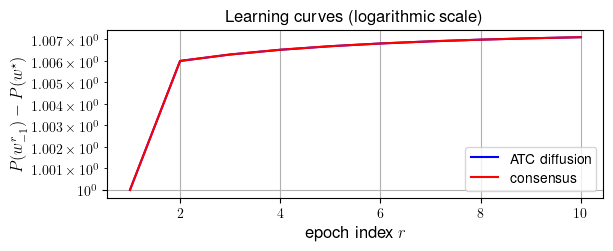

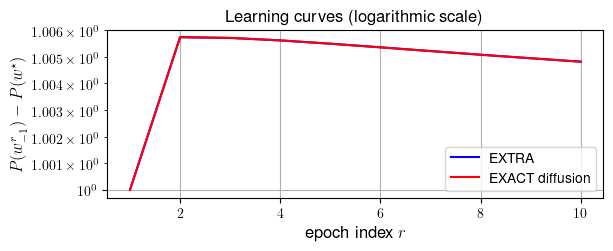

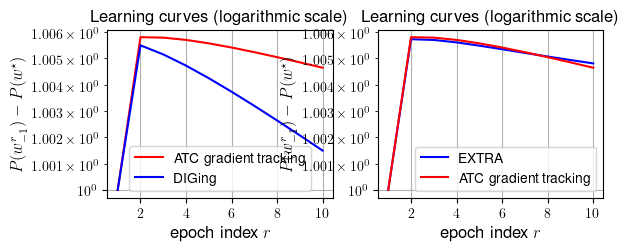

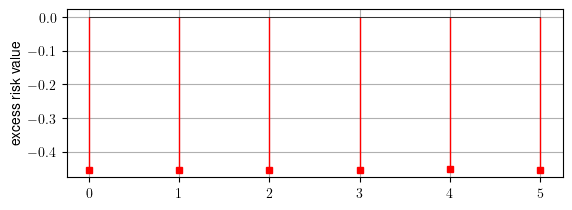

In [55]:
P_ATC_mean  = np.mean(P_ATC, axis = 1).reshape(-1,1)
P_CONS_mean = np.mean(P_CONS, axis = 1).reshape(-1,1)
P_EXTRA_mean = np.mean(P_EXTRA, axis = 1).reshape(-1,1)
P_EXACT_mean = np.mean(P_EXACT, axis = 1).reshape(-1,1)
P_GRAD_mean = np.mean(P_GRAD, axis = 1).reshape(-1,1)
P_DING_mean = np.mean(P_DING, axis = 1).reshape(-1,1)

print('checkpoint 7')

# Display global minimizers
print('Global minimizer, ATC diffusion, consensus, EXTRA, EXACT diffusion, ATC gradient tracking')
print(wstar,',\n', w_ATC[:, random_agent], ',\n', w_CONS[:, random_agent], ',\n', w_EXTRA[:, random_agent], ',\n', 
      w_EXACT[:, random_agent], ',\n', w_GRAD[:, random_agent])

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

# Figure 8 from Chapter 25 (diffusion vs consensus)
plt.figure()
plt.subplot(211)
plt.semilogy(range(1, runs + 1), (P_ATC_mean - Pstar) / max(P_ATC_mean - Pstar), '-b',
             range(1, runs + 1), (P_CONS_mean - Pstar) / max(P_CONS_mean - Pstar), '-r')
plt.xlabel('epoch index $r$', fontsize=12)
plt.ylabel('$P(w_{-1}^r) - P(w^\star)$', fontsize=12)
plt.title('Learning curves (logarithmic scale)', fontsize=12)
plt.legend(['ATC diffusion', 'consensus'])
plt.grid()
plt.axis('tight')

# Figure 1 from Chapter 26 (EXTRA vs EXACT diffusion)
plt.figure()
plt.subplot(211)
plt.semilogy(range(1, runs + 1), (P_EXTRA_mean - Pstar) / max(P_EXTRA_mean - Pstar), '-b',
             range(1, runs + 1), (P_EXACT_mean - Pstar) / max(P_EXACT_mean - Pstar), '-r')
plt.xlabel('epoch index $r$', fontsize=12)
plt.ylabel('$P(w_{-1}^r) - P(w^\star)$', fontsize=12)
plt.title('Learning curves (logarithmic scale)', fontsize=12)
plt.legend(['EXTRA', 'EXACT diffusion'])
plt.grid()
plt.axis('tight')

# Figure 2 from Chapter 26 (DIGing vs ATC tracking)
plt.figure()
plt.subplot(221)
plt.semilogy(range(1, runs + 1), (P_GRAD_mean - Pstar) / max(P_GRAD_mean - Pstar), '-r',
             range(1, runs + 1), (P_DING_mean - Pstar) / max(P_DING_mean - Pstar), '-b')
plt.xlabel('epoch index $r$', fontsize=12)
plt.ylabel('$P(w_{-1}^r) - P(w^\star)$', fontsize=12)
plt.title('Learning curves (logarithmic scale)', fontsize=12)
plt.legend(['ATC gradient tracking', 'DIGing'])
plt.grid()
plt.axis('tight')

plt.subplot(222)
plt.semilogy(range(1, runs + 1), (P_EXTRA_mean - Pstar) / max(P_EXTRA_mean - Pstar), '-b',
             range(1, runs + 1), (P_GRAD_mean - Pstar) / max(P_GRAD_mean - Pstar), '-r')
plt.xlabel('epoch index $r$', fontsize=12)
plt.ylabel('$P(w_{-1}^r) - P(w^\star)$', fontsize=12)
plt.title('Learning curves (logarithmic scale)', fontsize=12)
plt.legend(['EXTRA', 'ATC gradient tracking'])
plt.grid()
plt.axis('tight')

# Steady-state risk values; average of last samples
P_ATC_ss = np.mean(P_ATC_mean[runs - 20 : runs])
P_CONS_ss = np.mean(P_CONS_mean[runs - 20 : runs])
P_EXACT_ss = np.mean(P_EXACT_mean[runs - 20 : runs])
P_EXTRA_ss = np.mean(P_EXTRA_mean[runs - 20 : runs])
P_DING_ss = np.mean(P_DING_mean[runs - 20 : runs])
P_GRAD_ss = np.mean(P_GRAD_mean[runs - 20 : runs])

min_risk = [P_ATC_ss, P_CONS_ss, P_EXACT_ss, P_EXTRA_ss, P_DING_ss, P_GRAD_ss]
names = ['ATC diffusion', 'Consensus', 'EXACT diffusion', 'EXTRA', 'DIGing', 'Grad tracking']

plt.figure()
plt.subplot(211)
markerline, stemlines, baseline = plt.stem(min_risk - Pstar[0], markerfmt='rs', linefmt='r', basefmt='k')
stemlines.set_linewidth(1)
baseline.set_linewidth(0.5)
markerline.set_markersize(4)
plt.ylabel('excess risk value')
plt.axis('tight')
plt.grid()

plt.show()